In [ ]:
import sys
import scipy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import qmc
from perlin_numpy import generate_fractal_noise_2d
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from numpy import pi, exp, sqrt
from numpy.fft import fft2, fftshift, ifftshift

np.set_printoptions(threshold=sys.maxsize)

In [5]:
def image_norm(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

def gauss_create(x, y, size, sigma, center = False):
  if center:
    x_c = 0
    y_c = 0
  else:
    x_c, y_c = np.random.randn(2,1) * size/5 + 0.5
  gauss = exp(-((x - x_c)**2+(y - y_c)**2) / sigma)
  return gauss

def nearest_odd(number):
  if number%2==0:
    return number-1
  else:
    return number

In [ ]:
class cell():
  def __init__(self, cell_size: int):
    self._size = cell_size
    cell_sigma = cell_size ** 2 / 8
    x_deform = np.random.rand() * 0.5 + 0.5
    y_deform = np.random.rand() * 0.5 + 0.5
    x, y = np.meshgrid(np.arange(-cell_size / 2, cell_size / 2) + 0.5, np.arange(-cell_size / 2, cell_size / 2) + 0.5)
    circle_mask = exp(-((x ** 2 / x_deform + y ** 2 / y_deform) / cell_sigma) ** 6)

    N = 100
    cell = gauss_create(x, y, cell_size, cell_size * 2, True)
    for l in range(N):
        cell = cell + gauss_create(x, y, cell_size, cell_size ** 2 / 128)
    cell = circle_mask * cell
    self._cell = image_norm(cell)
    self._x = self._size//2
    self._y = self._size//2
    self._cell_type = 0

  def rect_bound(self):
    cell = self._cell
    cell = cell * 255
    cell = cell.astype(np.uint8)
    x, y, w, h = cv2.boundingRect(cell)
    return x, y, w, h

  def rotate(self, ang):
    center = (int(self._size / 2), int(self._size / 2))
    rotation_matrix = cv2.getRotationMatrix2D(center, ang, 1)
    self._cell = cv2.warpAffine(self._cell, rotation_matrix, (self._size, self._size))

  def normal_size(self, scaling_factor = 0.7):
    x0, y0, w, h = self.rect_bound()
    normal_f = self._size**2 * scaling_factor
    scale_f = sqrt(normal_f / (w*h))
    new_size = int(self._size * scale_f)
    self._cell = cv2.resize(self._cell, (new_size, new_size))
    if scale_f > 1:
      self._cell = self._cell[np.shape(self._cell)[0]//2 - self._size//2:np.shape(self._cell)[0]//2 + self._size//2, np.shape(self._cell)[1]//2 - self._size//2:np.shape(self._cell)[1]//2 + self._size//2]
    else:
      size_dif = self._size - new_size
      back = np.zeros((self._size, self._size))
      back[size_dif//2:size_dif//2 + new_size, size_dif//2:size_dif//2 + new_size] = self._cell
      self._cell = back

  def mask_create(self, thr = 0.05):
    cell_mask = scipy.signal.medfilt2d(self._cell, 9)
    cell_mask = np.clip(cell_mask, a_min=0, a_max=thr)
    cell_mask = image_norm(cell_mask) * 255
    cell_mask = np.uint16(cell_mask)
    th, cell_mask = cv2.threshold(cell_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cell_mask = image_norm(cell_mask)
    return cell_mask

  def scale_coeff_apply(self):
    x0,y0,w,h = self.rect_bound()
    scale_coeff = sqrt(np.linspace(0, 1, x0+w))
    scale_coeff = scale_coeff - np.min(scale_coeff)
    scale_coeff = scale_coeff / np.max(scale_coeff) * (x0+w)
    axis = np.arange(0,self._size)
    axis = axis.astype(float)
    axis[0:x0+w] = scale_coeff
    return axis

  def center(self):
    x0, y0, w, h = self.rect_bound()
    translation_matrix = np.float32([[1,0,self._size//2 - (x0 + w/2)],[0,1,self._size//2 - (y0 + h/2)]])
    self._cell = cv2.warpAffine(self._cell, translation_matrix, (self._size, self._size))

  def dots_create(self):
    self._cell = image_norm(self._cell)
    cell_mask = self.mask_create()
    x, y = np.meshgrid(np.arange(-self._size / 2, self._size / 2) + 0.5, np.arange(-self._size / 2, self._size / 2) + 0.5)

    for l in range(100):
        x_c, y_c = np.random.randn(2,1) * self._size/5 + 0.5
        dot = exp(-((x - x_c)**2+(y - y_c)**2) / (self._size ** 2 / 2048 * sqrt(x_c**2 + y_c**2)/(self._size*0.2)))
        dot = image_norm(dot) * np.random.rand() / 8
        self._cell = self._cell - dot
    self._cell = self._cell * cell_mask
    self._cell = np.clip(self._cell, a_min=0, a_max=1)

  def ring_create(self):
    ring = scipy.signal.medfilt2d(self._cell, 9)
    ring = np.clip(ring, a_min=0, a_max=0.1)
    ring = image_norm(ring)
    ring = ring - (ring==1)
    ring = cv2.GaussianBlur(ring, (5,5), 0)
    self._cell = self._cell + ring / self._size*10

  def deform_cell(self):
    xx = self.scale_coeff_apply()
    xx = xx.astype(np.float32)
    yy = np.arange(0,self._size) + 1
    yy = yy.astype(np.float32)
    x1, y1 = np.meshgrid(xx, yy)

    self._cell = cv2.remap(self._cell, y1, x1, cv2.INTER_LANCZOS4)
    self.center()
    ang_rand = np.random.rand()*360
    self.rotate(ang_rand)
    cell_mask = self.mask_create()
    self._cell = self._cell * cell_mask
    self._cell = scipy.signal.medfilt2d(self._cell, 9) / 1.5
    self.normal_size()
    self.center()

  def deform_border(self):
    x, y = np.meshgrid(np.arange(-self._size / 2, self._size / 2) + 0.5, np.arange(-self._size / 2, self._size / 2) + 0.5)
    r_c = self.border_coordinates_gain()
    sum = np.zeros(np.shape(x))

    for i in range(20):
      x_c, y_c = r_c[np.random.randint(low=0, high=np.shape(r_c)[0]), :]
      gauss = exp(-((x - x_c)**2+(y - y_c)**2) / (self._size**2 / 64))
      sum = 1 - image_norm(gauss)
      mask = self.mask_create()
      mask = sum * mask
      self._cell = self._cell * mask
    self._cell = cv2.GaussianBlur(self._cell, (7,7), 0)
    mask = self.mask_create(thr=0.01)
    self._cell = self._cell * mask
    self.normal_size()
    self.center()

  def border_coordinates_gain(self):
    x, y = np.meshgrid(np.arange(-self._size / 2, self._size / 2) + 0.5, np.arange(-self._size / 2, self._size / 2) + 0.5)

    ring = scipy.signal.medfilt2d(self._cell, 9)
    ring = np.clip(ring, a_min=0, a_max=0.05)
    ring = image_norm(ring)
    ring = ring - (ring==1)
    ring = ring!=0
    x_ring = (ring * x)
    y_ring = (ring * y)

    ring_coordinates = np.stack((x_ring, y_ring), axis=-1)
    ring_coordinates = np.reshape(ring_coordinates, [self._size**2, 2])
    ring_coordinates = ring_coordinates[np.sum(ring_coordinates, axis=-1)!=0]
    return ring_coordinates

  def update_coordinates(self, point):
    self._x = point[0]
    self._y = point[1]

  def move(self, velocity):
    self._x = self._x + velocity[0] + np.random.randint(low=int(-velocity[0]*0.1), high=int(velocity[0]*0.1+1))
    self._y = self._y + velocity[1] + np.random.randint(low=int(-velocity[1]*0.1), high=int(velocity[1]*0.1+1))
    self.rotate(np.random.randint(low=-30, high=31))

  def save_phase_as_img(self, name):
    img = image_norm(self.phase)*255
    cv2.imwrite(name, img.astype(dtype=np.uint8))

  @property
  def amplitude(self):
    self._amplitude = scipy.signal.medfilt2d(self._cell, nearest_odd(int(sqrt(self._size)*1.5)))
    self._amplitude = image_norm(self._amplitude)
    self._amplitude = cv2.GaussianBlur(self._amplitude, (7,7), 0)
    mask = self.mask_create()
    self._amplitude = self._amplitude * mask
    self._amplitude = 1 - 0.5*self._amplitude
    return self._amplitude

  @property
  def phase(self):
    return self._cell * 10 * 2* pi
  
  @property
  def complex(self):
    return self.amplitude*exp(1j*self.phase)

  @property
  def coordinates(self):
    return [self._x, self._y]

  @property
  def size(self):
    return self._size
  
  @property
  def cell_type(self):
    return self._cell_type

  def show(self):
    f, [a1, a2] = plt.subplots(1,2)
    a1.imshow(self.phase)
    a2.imshow(self.amplitude, vmin=0, vmax=1)
    plt.show()

In [7]:
class normal_cell(cell):
  def __init__(self, cell_size: int):
    super().__init__(cell_size)
    self._cell_type = 1
    self.dots_create()    
    self.ring_create()    
    self.normal_size(scaling_factor=0.5)
    

In [8]:
class defect_cell(cell):
  def __init__(self, cell_size: int):
    super().__init__(cell_size)
    self._cell_type = 2    
    x, y = np.meshgrid(np.arange(-cell_size / 2, cell_size / 2) + 0.5, np.arange(-cell_size / 2, cell_size / 2) + 0.5)
    self.deform_border()    
    self.deform_cell()    
    self.deform_border()    
    self.deform_cell()    
    N = 50
    cell = gauss_create(x, y, cell_size, cell_size * 2, True)
    for l in range(N):
        cell = cell + gauss_create(x, y, cell_size, cell_size ** 2 / 128)
    self._cell = self._cell * cell
    self._cell = image_norm(self._cell)    
    self.dots_create()   

In [9]:
class field():
  def __init__(self, field_size: int, cell_number: int, cell_size: int):
    self._size = field_size
    custom_back = generate_fractal_noise_2d((self._size, self._size), (4, 4), 3)
    self._field = image_norm(custom_back)
    self._cell_size = cell_size
    self._cell_number = cell_number
    self._cell_list = self._starting_cells()
    self._f_max = np.max(self._field * 2*pi)

  def update_field(self):
    custom_back = generate_fractal_noise_2d((self._size, self._size), (4, 4), 3)
    self._field = image_norm(custom_back)

    new_field_size = self._size + self._cell_size*2
    new_field = np.zeros((new_field_size, new_field_size))
    new_field[self._cell_size:self._size + self._cell_size, self._cell_size:self._size + self._cell_size] = self._field
    self._field = new_field

  @property
  def phase(self):
    return self._field[self._cell_size:self._cell_size + self._size, self._cell_size:self._cell_size + self._size] * 2 * pi

  @property
  def amplitude(self):
    self._amplitude = scipy.signal.medfilt2d(self._field, nearest_odd(int(sqrt(self._size)*1.5)))
    self._amplitude = image_norm(self._amplitude)
    self._amplitude = cv2.GaussianBlur(self._amplitude, (7,7), 0)
    self._amplitude = 1 - 0.5*self._amplitude
    return self._amplitude[self._cell_size:self._cell_size + self._size, self._cell_size:self._cell_size + self._size]

  @property
  def complex(self):
    return self.amplitude*exp(1j*self.phase)

  def place_cell(self, cell_to_place):
    x, y = cell_to_place.coordinates
    self._field[int(x) - cell_to_place.size//2:int(x) + cell_to_place.size//2, int(y) - cell_to_place.size//2:int(y) + cell_to_place.size//2] = \
      self._field[int(x) - cell_to_place.size//2:int(x) + cell_to_place.size//2, int(y) - cell_to_place.size//2:int(y) + cell_to_place.size//2] + cell_to_place.phase/ (2*pi)

  def _cell_centers_create(self):
    new_field_size = self._size + self._cell_size*2
    new_field = np.zeros((new_field_size, new_field_size))
    new_field[self._cell_size:self._size + self._cell_size, self._cell_size:self._size + self._cell_size] = self._field
    self._field = new_field

    N_points = self._cell_number
    Nd = 2
    SIZE = self._size - self._cell_size
    r = self._cell_size / SIZE

    engine = qmc.PoissonDisk(d=Nd, radius=r)
    points = engine.random(N_points)
    points = points.transpose()

    for axis in range(Nd):
        points[axis] = points[axis] - np.min(points, axis=1)[axis]
        points[axis] = points[axis] / np.max(points, axis=1)[axis] * SIZE
    points = points + 3 * self._cell_size//2
    return np.round(points.transpose())

  def _starting_cells(self):
    centers = self._cell_centers_create()
    cell_list = []
    defect_number = 0
    normal_number = 0
    for c in centers:
      d_or_n = np.round(np.random.rand(1))
      if d_or_n:
        cell_i = normal_cell(self._cell_size)
      else:
        cell_i = defect_cell(self._cell_size)
      cell_i.update_coordinates(c + np.random.randint(low=-int(self._cell_size*0.2), high=int(self._cell_size*0.2 + 1), size=(2)))
      self.place_cell(cell_i)
      cell_list.append(cell_i)
    return cell_list

  def move_cells(self, velocity):
    self._v = velocity
    self.update_field()
    index_to_del = []
    coordinates_to_place = []
    for i, cell_sample in enumerate(self._cell_list):
      try:
        cell_sample.move(velocity)
        self.place_cell(cell_sample)
      except Exception:
        c_end = cell_sample.coordinates
        new_c = self._new_center_find(c_end)
        coordinates_to_place.append(new_c)
        index_to_del.append(i)
    if index_to_del:
      for i in index_to_del[::-1]:
        del self._cell_list[i]
    if coordinates_to_place:
      for new_coordinates in coordinates_to_place:
        d_or_n = np.round(np.random.rand(1))
        if d_or_n:
          cell_i = normal_cell(self._cell_size)
        else:
          cell_i = defect_cell(self._cell_size)
        cell_i.update_coordinates(new_coordinates)
        self.place_cell(cell_i)
        self._cell_list.append(cell_i)

  def _new_center_find(self, c_end):
    ve = np.array(self._v) / sqrt(self._v[0]**2 + self._v[1]**2)
    lbd = -(self._cell_size//2 - c_end[1]) / ve[1]
    rbd = -(3*self._cell_size//2 + self._size - c_end[1]) / ve[1]
    tbd = -(self._cell_size//2 - c_end[0]) / ve[0]
    bbd = -(3*self._cell_size//2 + self._size - c_end[0]) / ve[0]

    r_dist = np.array([[bbd, tbd], [rbd, lbd]])

    s = np.min(np.max(r_dist, -1))
    new_c = c_end - s * ve
    return new_c.astype(int)

  def show(self, whole=False):
    f, [a1, a2] = plt.subplots(1,2)
    a1.imshow(self.phase, vmin=0, vmax=self._f_max)
    a2.imshow(self.amplitude, vmin=0, vmax=1)
    plt.show()

  @property
  def coordinates(self):
      c_arr = []
      for c in self._cell_list:
          x, y = c.coordinates
          x_local = x - self._cell_size
          y_local = y - self._cell_size
          c_arr.append([x_local, y_local, c.cell_type])
      
      return np.array(c_arr)
  
  def show(self):
    f, [a1, a2] = plt.subplots(1,2)
    a1.imshow(self.phase)
    a2.imshow(self.amplitude, vmin=0, vmax=1)
    plt.show()

In [10]:
def holo_create_Frensel(field):
    k = 2 * pi / wl
    X, Y = np.meshgrid(np.arange(-Np // 2, Np // 2), np.arange(-Np // 2, Np // 2))
    img_pix = wl * z / (Np * hol_pix)
    u = hol_pix * X
    v = hol_pix * Y
    x = img_pix * X
    y = img_pix * Y

    c1 = exp(1j * k * z) / (1j * wl * z) * exp(1j * pi * (u ** 2 + v ** 2) / (wl * z))
    c2 = field * exp(1j * pi * (x ** 2 + y ** 2) / (wl * z))
    obj = c1 * fftshift(fft2(ifftshift(c2)))

    ref = sqrt(np.mean(np.abs(obj) ** 2))
    holo = obj + ref
    holo = np.abs(holo) ** 2
    holo = holo / np.max(holo)
    return holo

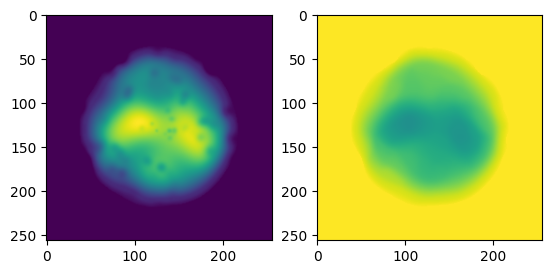

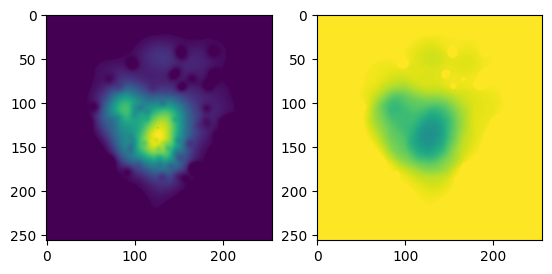

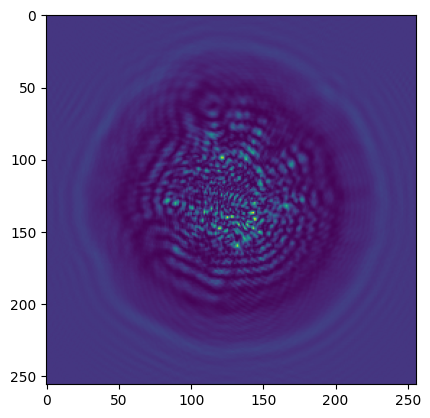

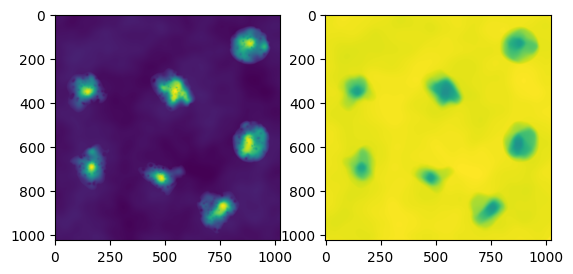

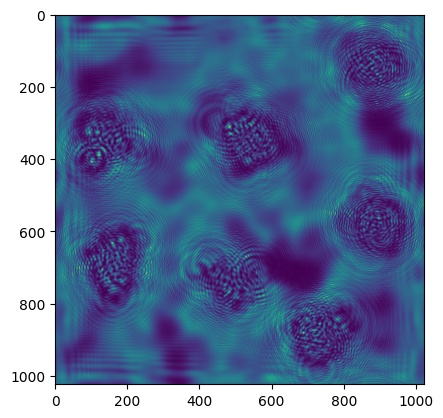

In [11]:
Np = 256
hol_pix = 9e-6
wl = 532e-9
nz0 = 1
z0 = (Np * hol_pix ** 2) / wl
z = nz0 * z0

c1 = normal_cell(Np)
c1.show()
c2 = defect_cell(Np)
c2.show()

holo = holo_create_Frensel(c1.complex)
plt.imshow(holo)
plt.show()

Np = Np*4
hol_pix = 9e-6
wl = 532e-9
nz0 = 1
z0 = (Np * hol_pix ** 2) / wl
z = nz0 * z0

f1=field(Np, 10, int(Np/4))
f1.show()
holo = holo_create_Frensel(f1.complex)
plt.imshow(holo)
plt.show()